In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

## Prepare Dataset

### Read Dataset

In [2]:
fake_df = pd.read_csv("./Fake.csv")
true_df = pd.read_csv("./True.csv")

In [3]:
fake_df.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [4]:
fake_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23481 entries, 0 to 23480
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    23481 non-null  object
 1   text     23481 non-null  object
 2   subject  23481 non-null  object
 3   date     23481 non-null  object
dtypes: object(4)
memory usage: 733.9+ KB


In [5]:
fake_df.describe()

,title,text,subject,date
count,23481,23481,23481,23481
unique,17903,17455,6,1681
top,MEDIA IGNORES Time That Bill Clinton FIRED His...,,News,"May 10, 2017"
freq,6,626,9050,46


In [6]:
true_df.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


In [7]:
true_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21417 entries, 0 to 21416
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    21417 non-null  object
 1   text     21417 non-null  object
 2   subject  21417 non-null  object
 3   date     21417 non-null  object
dtypes: object(4)
memory usage: 669.4+ KB


In [8]:
true_df.describe()

,title,text,subject,date
count,21417,21417,21417,21417
unique,20826,21192,2,716
top,Factbox: Trump fills top jobs for his administ...,(Reuters) - Highlights for U.S. President Dona...,politicsNews,"December 20, 2017"
freq,14,8,11272,182


### EDA

In [9]:
def plotbh(df, col):
    '''Draw boxplot and histogram for numerical variables'''
    fig, axs = plt.subplots(1, 2, figsize=(18, 6))

    # Boxplot
    sns.boxplot(x=df[col], ax=axs[0])
    axs[0].set_title('Box chart of ' + col)

    # Histogram
    sns.histplot(data=df, x=col, kde=True, ax=axs[1])
    axs[1].set_title('Histogram of ' + col)

    plt.tight_layout()
    plt.show()

In [10]:
fake_df['word_count'] = fake_df['text'].apply(lambda x : len(x.split()))
fake_df['word_count'].describe()

count    23481.000000
mean       423.197905
std        408.388890
min          0.000000
25%        240.000000
50%        363.000000
75%        506.000000
max       8135.000000
Name: word_count, dtype: float64

In [11]:
fake_df_empty_strings_count = fake_df[fake_df['word_count'] == 0].shape[0]
fake_df_empty_strings_count

630

In [12]:
# Delete innocent text rows
fake_df = fake_df[fake_df['word_count'] > 0].reset_index(drop=True)

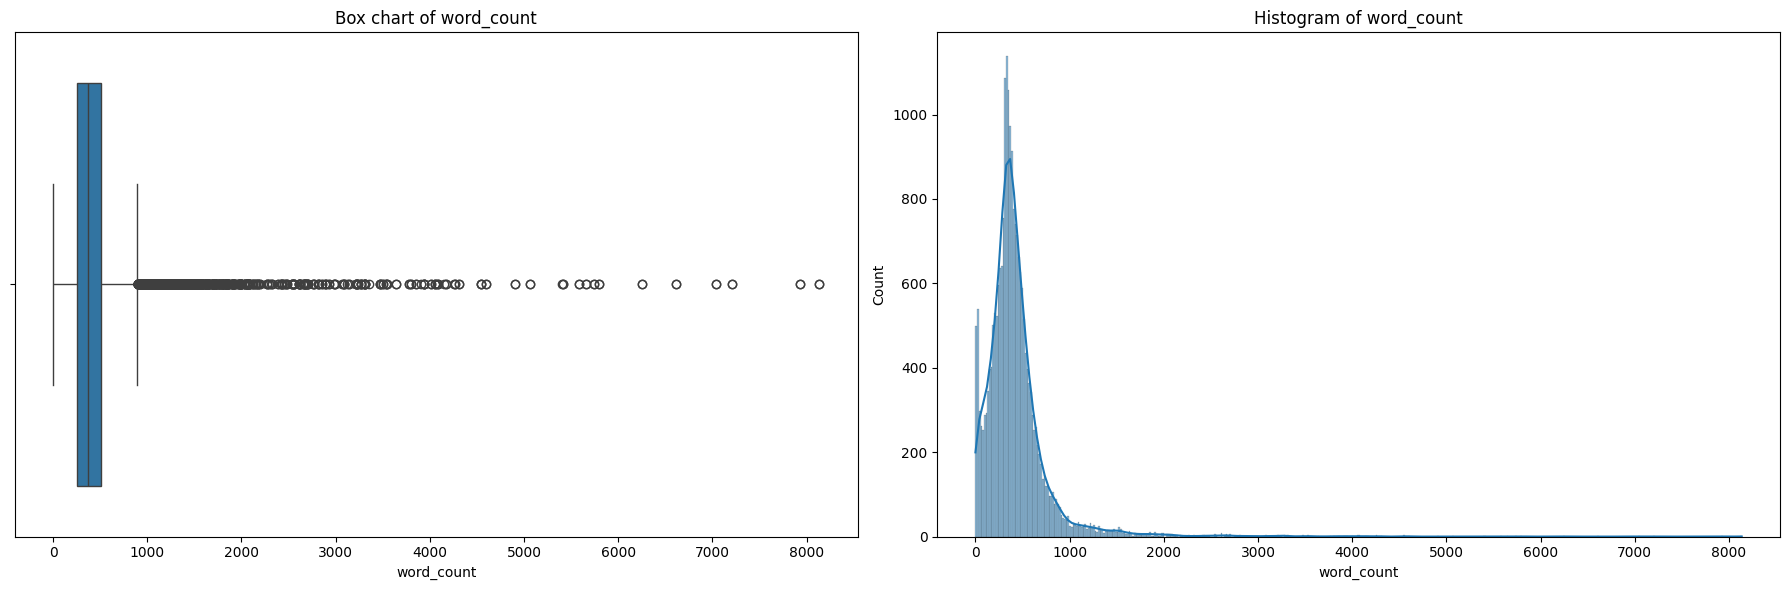

In [13]:
plotbh(fake_df, 'word_count')

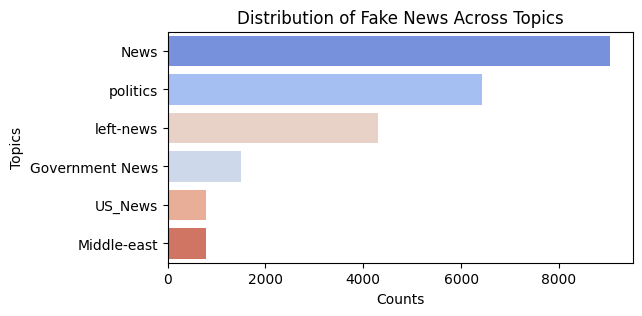

In [14]:
topics = fake_df['subject'].value_counts().sort_values(ascending=False)
plt.figure(figsize=(6, 3))
sns.countplot(y='subject', data=fake_df, order=topics.index,
              hue=fake_df['subject'], palette="coolwarm")
plt.title('Distribution of Fake News Across Topics')
plt.xlabel('Counts')
plt.ylabel('Topics')
plt.show()

In [15]:
true_df['word_count'] = true_df['text'].apply(lambda x : len(x.split()))
true_df['word_count'].describe()

count    21417.000000
mean       385.640099
std        274.006204
min          0.000000
25%        148.000000
50%        359.000000
75%        525.000000
max       5172.000000
Name: word_count, dtype: float64

In [16]:
true_df_empty_strings_count = true_df[true_df['word_count'] == 0].shape[0]
true_df_empty_strings_count

1

In [17]:
true_df = true_df[true_df['word_count'] > 0].reset_index(drop=True)

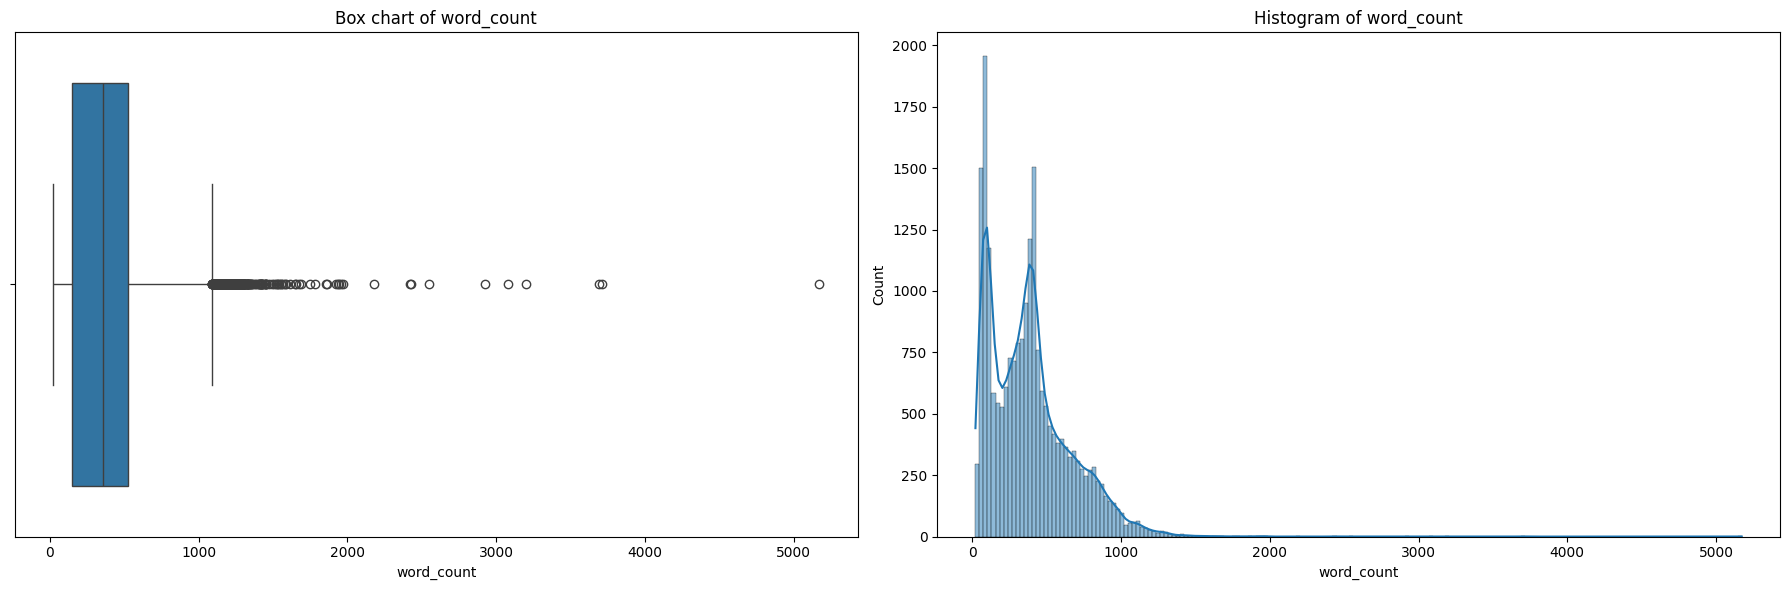

In [18]:
plotbh(true_df, 'word_count')

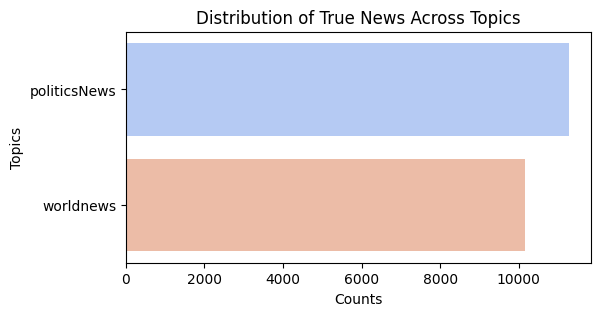

In [19]:
topics = true_df['subject'].value_counts().sort_values(ascending=False)
plt.figure(figsize=(6, 3))
sns.countplot(y='subject', data=true_df, order=topics.index,
              hue=true_df['subject'], palette="coolwarm")
plt.title('Distribution of True News Across Topics')
plt.xlabel('Counts')
plt.ylabel('Topics')
plt.show()

## Pre-process Data

### Concatenate Fake and True as single Data Source

## Training Model